In [1]:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from imutils import paths
import shutil
import os

c:\Users\ginny\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ginny\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ginny\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# use gpu or cpu
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

Take ResNet18 network architecture. See https://pytorch.org/vision/stable/models.html and Load in the pre-trained weights. See again https://pytorch.org/vision/stable/models.html. 

In [3]:
from torchvision.models import resnet18, ResNet18_Weights
# Using pretrained weights:
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights = weights)  # deprecated
model = resnet18(True)  # deprecated
model.eval()

C:\Users\ginny\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\ginny\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
def replace_last_layer(model):
    # get the number of input features of the last layer
    num_ftrs = model.fc.in_features
    # replace the last layer with a new one followed by the sigmoid layer
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 1, bias=True), nn.Sigmoid()) 
    return model

# Replace the last layer with a fully connected layer followed by a sigmoid activation function
model = replace_last_layer(model)

In [5]:
for param in model.parameters():
    # Freeze all the layers 
    param.requires_grad = False
# Unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True

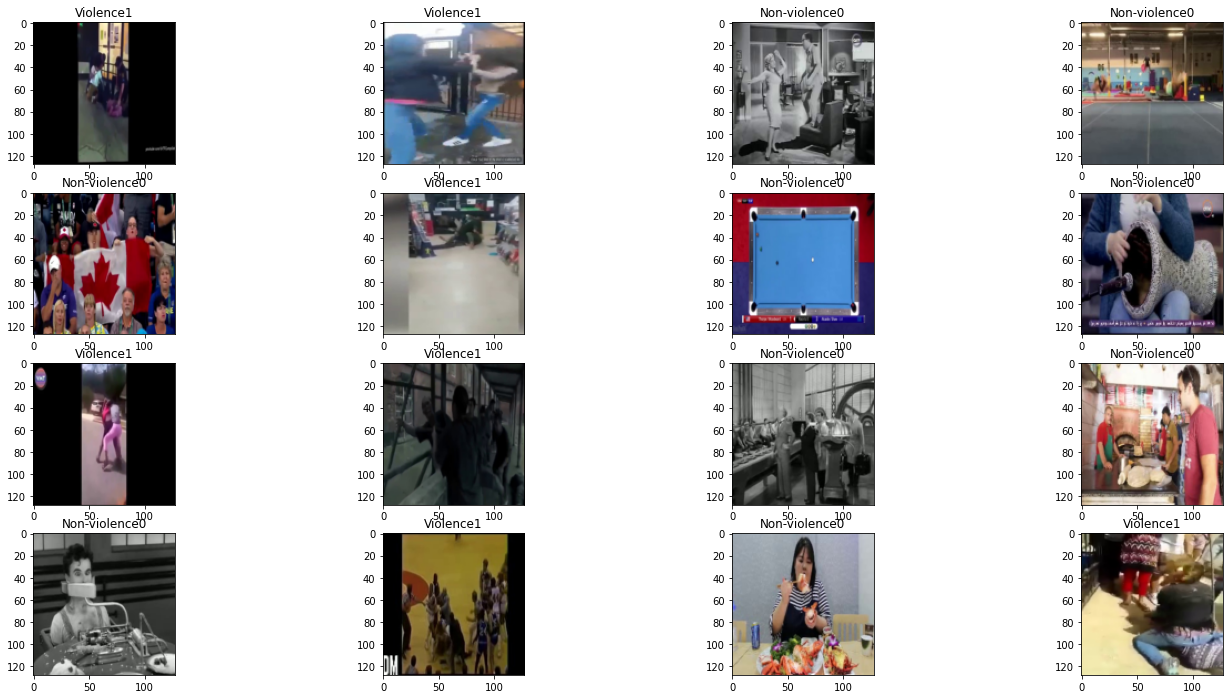

In [6]:
# To resize images, convert to tensor images and normalize them
img_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0, 0, 0),(1, 1, 1))])
# Load the dataset
train_imgs = torchvision.datasets.ImageFolder(root='C:/Users/ginny/projects/final_project_holder/Real_Life_Violence_Dataset/train_', transform=img_transforms)
val_imgs = torchvision.datasets.ImageFolder(root='C:/Users/ginny/projects/final_project_holder/Real_Life_Violence_Dataset/val_', transform=img_transforms)
test_imgs = torchvision.datasets.ImageFolder(root='C:/Users/ginny/projects/final_project_holder/Real_Life_Violence_Dataset/test_', transform=img_transforms)
# Create the dataloaders
train_data_loader = torch.utils.data.DataLoader(train_imgs, batch_size=16, shuffle=True, num_workers=4)
val_data_loader = torch.utils.data.DataLoader(val_imgs, batch_size=16, shuffle=False, num_workers=4)
test_data_loader = torch.utils.data.DataLoader(test_imgs, batch_size=16, shuffle=False, num_workers=4)

# Print the number of images in a batch
fig, ax = plt.subplots(4, 4, figsize=(24,12))
for images, labels in train_data_loader:
    for i in range(len(images)):
        ax[i//4, i%4].imshow(images[i].permute(1, 2, 0))
        if labels[i] == 0:
            ax[i//4, i%4].set_title('Non-violence' + str(labels[i].item()))
        else:
            ax[i//4, i%4].set_title('Violence' + str(labels[i].item()))
    break

# To calculate the accuracy
def accuracy(preds, trues):
    total_accuracy = 0
    # Convert preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    for i in range(len(preds)):
        if preds[i] == trues[i]:
            total_accuracy += 1
    acc = (total_accuracy / len(preds)) * 100
    return acc
def train_one_epoch(train_data_loader, computeLoss, optimizer, train_loss, train_accuracy, model):
    epoch_loss = []
    epoch_acc = []
    for images, labels in train_data_loader:
        #Load images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        # Reshape to match with predictions shape
        labels = labels.reshape((labels.shape[0], 1)) 
        #Reset Gradients
        optimizer.zero_grad()
        #Forward
        predictions = model(images)
        #Recasting  to float
        predictions = predictions.to(torch.float32)
        labels = labels.to(torch.float32)
        #Compute Loss and add to epoch loss
        loss = computeLoss(predictions, labels)
        epoch_loss.append(loss.item())
        #Calculating Accuracy and adding to epoch accuracy
        acc = accuracy(predictions, labels)
        epoch_acc.append(acc)
        #Backward
        loss.backward()
        # Update Weights
        optimizer.step()
    # Average Loss and Accuracy
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    # Add to tracking train logs
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    return epoch_loss, epoch_acc
     
def val_one_epoch(val_data_loader, best_val_acc, computeLoss, val_loss, val_accuracy, model):
    epoch_loss = []
    epoch_acc = []
    for images, labels in val_data_loader:
        #Load images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        # Reshape to match with predictions shape
        labels = labels.reshape((labels.shape[0], 1))  
        #Forward
        predictions = model(images)
        #Recasting  to float
        predictions = predictions.to(torch.float32)
        labels = labels.to(torch.float32)
        #Calculating Loss
        loss = computeLoss(predictions, labels)
        epoch_loss.append(loss.item())
        #Calculating Accuracy
        acc = accuracy(predictions, labels)
        epoch_acc.append(acc)
    # Average Loss and Accuracy
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    # Add to validation logs
    val_loss.append(epoch_loss)
    val_accuracy.append(epoch_acc)
    # Check and save if best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet18_best.pth")
        print("Model saved, best accuracy: %f" %(best_val_acc))
    return epoch_loss, epoch_acc, best_val_acc

# Training and Evaluation
def train_and_evaluate(train_data_loader, val_data_loader, computeLoss, optimizer, epochs, model):
    best_val_acc = 0
    # Logs - Helpful for plotting after training finishes
    train_loss = [] 
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    for epoch in range(epochs):
        #Training
        loss, acc = train_one_epoch(train_data_loader, computeLoss, optimizer, train_loss, train_accuracy, model)
        #Print Epoch Details
        print("\nTraining, Epoch: %d, Loss: %f, Accuracy: %f" % (epoch, loss, acc))
        #Validation
        loss, acc, best_val_acc = val_one_epoch(val_data_loader, best_val_acc, computeLoss, val_loss, val_accuracy, model)
        #Print Epoch Details
        print("Validating, Epoch: %d, Loss: %f, Accuracy: %f" % (epoch, loss, acc))
    
    # Plot Results
    #Loss
    plt.title("Loss")
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    #Accuracy
    plt.title("Accuracy")
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

In [7]:
def printRandomPredictions(dataset, model):
    count = 0
    for images, labels in dataset:
        for i in range(len(images)):
            if count < 1:
                #Load images and labels to device
                image = images[i].to(device)
                label = labels[i].to(device)
                label_text = label.item()
                #Forward
                prediction = model(image.unsqueeze(0))
                _, pred = torch.max(prediction, 1)
                #Recasting  to float
                label = label.to(torch.float32)               
                pred = pred.to(torch.float32)
                print("Prediction: %d, Label: %d" % (pred, label_text))
                plt.imshow(image.cpu().permute(1, 2, 0))
                plt.show()
                count += 1

In [8]:
def test_model(test_data_loader, model, computeLoss):
    total_loss = []
    total_acc = []
    for images, labels in test_data_loader:
        #Load images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        # Reshape to match with predictions shape
        labels = labels.reshape((labels.shape[0], 1)) 
        #Forward
        predictions = model(images)
        #Recasting  to float
        predictions = predictions.to(torch.float32)
        labels = labels.to(torch.float32)
        #Compute Loss and add to epoch loss
        loss = computeLoss(predictions, labels)
        total_loss.append(loss.item())
        #Calculating Accuracy and adding to epoch accuracy
        acc = accuracy(predictions, labels)
        total_acc.append(acc)
    # Average Loss and Accuracy
    total_loss = np.mean(total_loss)
    total_acc = np.mean(total_acc)
    return total_loss, total_acc

In [9]:
for param in model.parameters():
    # Unfreeze all the layers 
    param.requires_grad = True
# Print to check if the all layers are unfreezed
"""count = 0
for param in model.parameters():
    print(count, param.requires_grad)
    count+=1"""

'count = 0\nfor param in model.parameters():\n    print(count, param.requires_grad)\n    count+=1'


Training, Epoch: 0, Loss: 0.035781, Accuracy: 98.665513
Model saved, best accuracy: 91.484139
Validating, Epoch: 0, Loss: 0.419841, Accuracy: 91.484139

Training, Epoch: 1, Loss: 0.006028, Accuracy: 99.798907
Model saved, best accuracy: 94.633686
Validating, Epoch: 1, Loss: 0.357686, Accuracy: 94.633686

Training, Epoch: 2, Loss: 0.003831, Accuracy: 99.869772
Validating, Epoch: 2, Loss: 0.368268, Accuracy: 94.233384

Training, Epoch: 3, Loss: 0.002988, Accuracy: 99.901064
Validating, Epoch: 3, Loss: 0.807135, Accuracy: 94.358006

Training, Epoch: 4, Loss: 0.002252, Accuracy: 99.917170
Validating, Epoch: 4, Loss: 0.603674, Accuracy: 94.573263


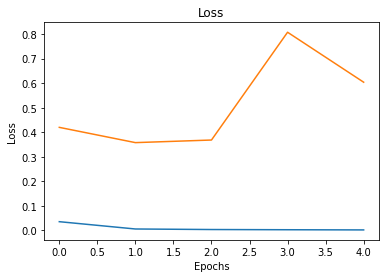

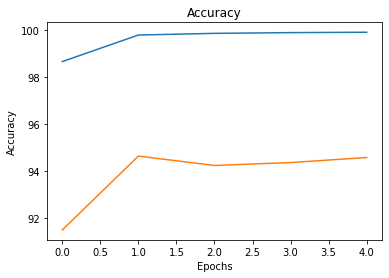

In [10]:
# Loading model to device
model.to(device)
# Loss and optimizer
computeLoss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5) 
epochs = 5
train_and_evaluate(train_data_loader, val_data_loader, computeLoss, optimizer, epochs, model)


Loss: 0.325476, Accuracy: 97.174312
Prediction: 0, Label: 0


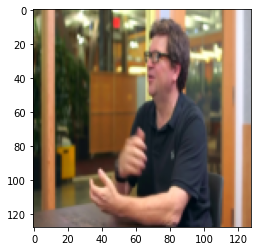

In [11]:
#Testing
loss, acc = test_model(test_data_loader, model, computeLoss)
#Print Epoch Details
print("\nLoss: %f, Accuracy: %f" % (loss, acc))
printRandomPredictions(test_data_loader, model)